# Summary

The Kaggle Disaster Tweets competition aims to fascillitate learning in natural language processing. With the increased use of social media in spreading emergency news, the objective of this competition is to use tweets to predict whether a natural disaster is occuring. The training data consists of 7613 tweets, each with a possible keyword, location, and text field as well as a hand-selected class label. Looking at null values, the training data is missing a location in about 1/3 of all tweets, but only 61/7613 keywords are missing. The text field, which is most important predictive variable for the models explored here, is found to have many special characters are parts of the tweets. While these could potentially be cleaned, they are left alone for now because of their potential relevance to the tweet's status as a disaster. For example, urls or special characters native to alert system tweets would be of particular interest. Upon searching for duplicates in the tweet texts, multiple instances of mislabelling was discovered. In these cases, tweets with the exact same text were given different class labels. To fix this issue, the texts were allocated to their respective classes by a majority vote and any split decisions where then manually labelled based on context. The text was then tokenized, and padded to an equal length for consistant model input.

Before exploring RNN models in depth, two baseline models were constructed for comparison. First a single flat layer linear regression is trained and then evaluated on a 20% validation set for an accuracy score of 50%. Then a simple single layer RNN is similarly fitted to the training data and evaluated on a 20% holdout set for an accuracy of 47%. To embellish on the simple RNN, the first model utilizes an embedding input layer to then feed into a bidirectional LSTM with 128 units followed by a Dense 256 node layer sandwiched between two 20% dropout layers for regularization to reduce overfitting. With a learning rate of 0.0001, batch size set to 128 and 10 epochs, this model results in a validation accuracy of 0.75 on the 20% holdout set. While the first epoch of this model yielded a validation accuracy of nearly 80%, the training accuracy was less than 73% in this case so stopping at this epoch is disregarded. Nevertheless, the second model aims to address the overfitting present in Model 1 by increasing the dropout layers from 20% to 50% and reducing the number of epochs from 10 to 5. This model shows similar results, with validation accuracies decreasing from about 0.79 to 0.75 over the course of the 5 epochs. Seeing no significant change from the regularization in Model 2, Model 3 takes a different approach by utilizing two bidirectional GRU layers in place of the LSTM layer. Unfortunately, this model also results in a validation accuracy of only about 75.5%. Future work would focus on incorporating the keyword feature, further exploration of text semantics and character patterns for system alert tweets, and hyperparameter tuning for number of epochs and batch sizes.


In [359]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU
from keras.layers import Dense, Embedding, Bidirectional, Dropout, Flatten, SimpleRNN
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

seed = 12345
tf.random.set_seed(seed)
from numpy.random import seed
seed(12345)

## Load Data

In [360]:
train = pd.read_csv(r'../input/nlp-getting-started/train.csv')
test = pd.read_csv(r'../input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv(r'../input/nlp-getting-started/sample_submission.csv')

In [361]:
train

## Investigating Training Data

In [362]:
train.isna().sum()

__Less than 1% of tweets are missing a keyword, but about 1/3 of training data tweets are missing a location. Removing these tweets from would severely reduce the available training data, so the NaN values should be imputed instead.__

In [363]:
train.keyword.value_counts()

In [364]:
train = train.fillna('missing')

In [365]:
# Check for identical tweet texts (potential duplicates)
duplicate_tweets = train[train.text.duplicated()]
duplicate_tweets = duplicate_tweets.sort_values(by='text')
duplicate_tweets

 - __Text cleaning needed, too many extra characters such as in "suicide%20bomb".__
 - __Inconsistant target labeling probably as a result of hand labeling. Same tweet text with differing target labels need to be consolidated.__

## Duplicate Texts with different targets

In [366]:
hellfire = train[train['text'].str.contains("hellfire", case=False)]
hellfire

In [367]:
train[train['text'].str.contains("hellfire", case=False)] = hellfire.assign(target=0)
duplicate_tweets = duplicate_tweets[~duplicate_tweets['text'].str.contains("hellfire", case=False)]

In [368]:
average_target = duplicate_tweets.groupby(by='text').mean()
average_target

In [369]:
for tweet_text in average_target.index:
    target = average_target['target'][tweet_text]
    
    if (target>0.5):
        train.loc[train['text']==tweet_text] = train.loc[train['text']==tweet_text].assign(target=1)
        average_target = average_target.drop(tweet_text)
    elif (target < 0.5):
        train.loc[train['text']==tweet_text] = train.loc[train['text']==tweet_text].assign(target=0)
        average_target = average_target.drop(tweet_text)

In [370]:
average_target

In [371]:
# Hand Label
train.loc[train['text']=='#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption'] = train.loc[train['text']=='#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption'].assign(target=1)
train.loc[train['text']=='CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring'] = train.loc[train['text']=='CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring'].assign(target=1)

# Only Using Location

In [372]:
loc_train = train.drop(['id', 'keyword', 'location'], axis=1)
loc_test = test.drop(['id', 'keyword', 'location'], axis=1)

In [373]:
loc_train

In [374]:
loc_train.drop(['target'], axis=1).shape

In [375]:
loc_y_train =  loc_train['target'].values
loc_X_train = loc_train.drop(['target'], axis=1).values.reshape(len(train),)
loc_X_test = loc_test['text'].values.reshape(len(test),)

### Preprocessing

In [376]:
total_tweets = np.concatenate((loc_X_train, loc_X_test))
print('Total tweets : ', len(total_tweets))

In [377]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_tweets)

# Vocab Size
vocab_size = len(tokenizer.word_index) + 1
print('Size of Vocabulary : ', vocab_size)

In [378]:
# Maximum length for padding sequence
maxlen = max(len(x.split()) for x in total_tweets)
print('Maximum length of tweet : ', maxlen)

In [379]:
# Tokenize tweet texts
loc_X_train_token = tokenizer.texts_to_sequences(loc_X_train)
loc_X_test_token = tokenizer.texts_to_sequences(loc_X_test)

In [380]:
# Pad tweets to same input size
loc_X_train_pad = pad_sequences(loc_X_train_token, maxlen=maxlen, padding='post')
loc_X_test_pad = pad_sequences(loc_X_test_token, maxlen=maxlen, padding='post')

### Baseline Models

In [381]:
#Linear Regression
lin_reg_model = Sequential([
    Flatten(input_shape=[maxlen,]),
    Dense(1)
])

lin_reg_model.compile(loss='mean_squared_error',
                        optimizer='Adam',
                        metrics=['accuracy'])

In [382]:
lin_reg_model_history = lin_reg_model.fit(loc_X_train_pad, loc_y_train, 
                                        batch_size=32, 
                                        epochs=20, 
                                        validation_split=0.2
                                        )

In [383]:
lin_reg_losses = pd.DataFrame(lin_reg_model_history.history)
lin_reg_losses.head()

In [384]:
#Ploting Loss Vs Val_Loss
lin_reg_losses[['loss','val_loss']].plot()

In [385]:
#Plotting  Accutacy vs Val_accuracy
lin_reg_losses[['accuracy','val_accuracy']].plot()

In [386]:
loc_y_train.shape

In [387]:
simple_rnn_loc_X_train_pad = loc_X_train_pad.reshape(-1, 1, 31)
simple_rnn_loc_y_train = loc_y_train.reshape(-1, 1)
input_shape=(1, 31)

In [388]:
#Simple RNN
simple_rnn_model = Sequential([
    SimpleRNN(1,input_shape=input_shape),
])

simple_rnn_model.compile(loss='mean_squared_error',
                        optimizer='Adam',
                        metrics=['accuracy'])

In [389]:

simple_rnn_model_history = simple_rnn_model.fit(simple_rnn_loc_X_train_pad, simple_rnn_loc_y_train, 
                                        batch_size=32, 
                                        epochs=20, 
                                        validation_split=0.2
                                        )

In [390]:
simple_rnn_losses = pd.DataFrame(simple_rnn_model_history.history)
simple_rnn_losses.head()

In [391]:
#Ploting Loss Vs Val_Loss
simple_rnn_losses[['loss','val_loss']].plot()

In [392]:
#Plotting  Accutacy vs Val_accuracy
simple_rnn_losses[['accuracy','val_accuracy']].plot()

### Model 1

In [393]:
hidden_units = 128
embed_units = 128

model_1 = Sequential()
model_1.add(Embedding(vocab_size, embed_units, input_length = maxlen))
model_1.add(Bidirectional(LSTM(hidden_units)))
model_1.add(Dropout(0.2))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(1, activation='sigmoid'))

model_1.summary()

In [394]:
learning_rate = 0.0001

model_1.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
batch_size = 128
epochs = 10
steps_per_epoch = loc_X_train_pad.shape[0] // batch_size

model_1_history = model_1.fit(loc_X_train_pad, loc_y_train, 
                          batch_size=batch_size, 
                          epochs=epochs,
                          steps_per_epoch = steps_per_epoch,
                          validation_split=0.2)

In [ ]:
model_1_losses = pd.DataFrame(model_1_history.history)
model_1_losses.head()

In [ ]:
#Ploting Loss Vs Val_Loss
model_1_losses[['loss','val_loss']].plot()

In [ ]:
#Ploting Loss Vs Val_Loss
model_1_losses[['accuracy','val_accuracy']].plot()

### Model 2 - 0.5 vs 0.2 Dropout Layers

In [ ]:
hidden_units = 128
embed_units = 128

model_2 = Sequential()
model_2.add(Embedding(vocab_size, embed_units, input_length = maxlen))
model_2.add(Bidirectional(LSTM(hidden_units)))
model_2.add(Dropout(0.5))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(1, activation='sigmoid'))

model_1.summary()

In [ ]:
learning_rate = 0.0001

model_2.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
batch_size = 128
epochs = 5
steps_per_epoch = loc_X_train_pad.shape[0] // batch_size

model_2_history = model_2.fit(loc_X_train_pad, loc_y_train, 
                          batch_size=batch_size, 
                          epochs=epochs,
                          steps_per_epoch = steps_per_epoch,
                          validation_split=0.2)

In [ ]:
model_2_losses = pd.DataFrame(model_2_history.history)
model_2_losses.head()

In [ ]:
#Ploting Loss Vs Val_Loss
model_2_losses[['loss','val_loss']].plot()

In [ ]:
#Ploting Loss Vs Val_Loss
model_2_losses[['accuracy','val_accuracy']].plot()

### Model 3 - Two GRU Layers

In [ ]:
hidden_units = 128
embed_units = 128

model_3 = Sequential()
model_3.add(Embedding(vocab_size, embed_units, input_length = maxlen))
model_3.add(Bidirectional(GRU(hidden_units,return_sequences=True)))
model_3.add(Bidirectional(GRU(hidden_units)))
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(1, activation='sigmoid'))

model_3.summary()

In [ ]:
learning_rate = 0.0001

model_3.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
loc_X_train_pad.shape[0] // batch_size

In [ ]:
batch_size = 512
epochs = 5
steps_per_epoch = loc_X_train_pad.shape[0] // batch_size

model_3_history = model_3.fit(loc_X_train_pad, loc_y_train, 
                          batch_size=batch_size, 
                          epochs=epochs,
                          steps_per_epoch = steps_per_epoch,
                          validation_split=0.2)

In [ ]:
model_3_losses = pd.DataFrame(model_3_history.history)
model_3_losses.head()

In [ ]:
#Ploting Loss Vs Val_Loss
model_3_losses[['loss','val_loss']].plot()

In [ ]:
#Ploting Loss Vs Val_Loss
model_3_losses[['accuracy','val_accuracy']].plot()

In [ ]:
pred = model_3.predict(loc_X_test_pad)

In [ ]:
sample_submission["target"] = pred
sample_submission["target"] = sample_submission["target"].apply(lambda x : 0 if x<=.5 else 1)
sample_submission.head()

In [ ]:
sample_submission.to_csv("model_3_RNN.csv", index=False)

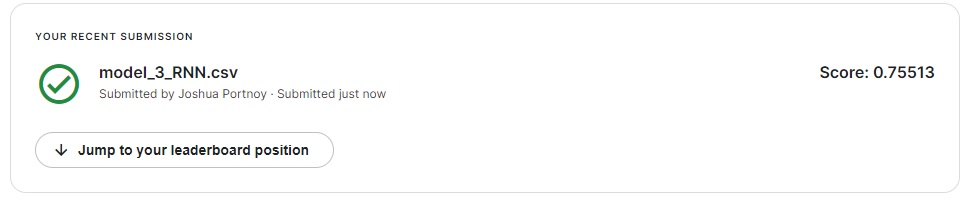